# Permutation test for paired data

Turning to the permutation test itself, we first look at the case of paired data - data in which we wish to compare two groups and each datapoint in one group has a counterpart in the other

Experimental designs using paired data include matched pairs (eg brothers and sisters) and repeated measures (measurements of the same individual before- and after- an intervention, or on- and off-drug).


### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set_theme(style='white')
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Toy example

[A toy example is an example with a very small dataset, just to show how it works]

#### Question & design

We suspect men own ore socks than women. 

We decide on a **matched pairs design** in which husbands are compared to their wives, as it is hypothesised that lifestyle factors such as the size of the home in which people live and the duration of holidays taken will affect the number of pairs that can be reasonably justified, and these lifestyle factors are generally shared by both members of a married couple.


#### Hypotheses

We can state our hypotheses as follows:

$\mathcal{H_o}:$ The mean sex difference quantity of socks owned is zero 
* on average a wife and her husband have the same number of pairs of socks

$\mathcal{H_a}:$ The mean sex difference [husband-wife] quantity of socks owned greater than zero
* on average a husband has more socks than his wife

#### Data

We obtain sock-counts for the following informal sample of 14 couples:

In [2]:
socks = pd.read_csv('https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/data/socks.csv')
socks

,Husband,Wife
0,10,12
1,17,13
2,48,20
3,28,25
4,23,18
5,16,14
6,18,13
7,34,26
8,27,22
9,22,14


Let's plot those data. 

For paired data a scatter plot is often a good choice, but actually for this tiny dataset, I prefer showing the pairs using a plot like that shown on the right. 
* You won't be required to reproduce this type plot for the course, however you can find instructions on how to make it in section 2.5 of this website


Why do I prefer the plot on the right? 

We are going to be interested in whether husbands have more socks than their wives or vice versa - I think this can be very clearly seen in the plot on the right (by inspecting whether the lines slope up or downwards)

*however* if there were 1000 couples in the sample rather than 10 this plot would be too crowded and hard to inspect


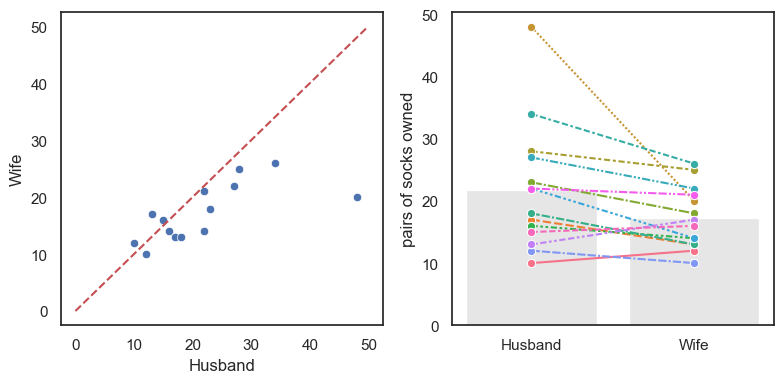

In [3]:
# Plotting code - don't get sidetracked by this, it's not that important
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.scatterplot(data=socks, x='Husband', y='Wife')
plt.plot([0,50],[0,50],'r--') # add the line x=y for comparison


plt.subplot(1,2,2)
sns.barplot(data=socks, errorbar=None, color=[0.9,0.9,0.9])
sns.lineplot(data=socks.T, legend=False, marker='o') # ci=None switches off errorbars
plt.ylabel('pairs of socks owned')

plt.tight_layout()
plt.show()

**Note-** 

* In most couples (11/14) the husband owns more socks that the wife
* There is one couple in which the husband has an extreme number of socks.

#### Test statistic

We need to sumamrize the sex difference as a number. 

Here, we are interested in the within-pairs difference in sock ownership, so we need the mean difference in pairs of socks owned, for [husband - wife].

This mean difference, <tt>mean(Husband-Wife)</tt>, is calculated as follows:

In [4]:
socks['difference'] = socks.Husband-socks.Wife # create a new column for the within-couple difference
socks.difference.mean()

4.571428571428571

On average, the husbands own 4.6 more pairs of socks than their wives.

### Is the result statistically significant? 

In our particular sample, husbands have (on average) more socks than their wives - our test statistic (<tt>mean(Husband-Wife)</tt>) is 4.6. 

However, even if there were no true sex differences in sock ownership, if we picked 10 random couples we wouldn't expect the average difference in number of socks owned to be *exactly zero* - just by chance the wives would sometimes have more socks than the husbands, or vice versa. 

Is it plausible that the sex difference we observed (husbands have 4.6 more pairs of socks than their wives) arose due to chance from a situation in which there is no true sex difference in sock ownership (ie, the *null hypothesis is true*?)

In that case, it would be just chance whether the person with more socks in each couple was the man or the woman.


### Permutation

To work out how likely it would be to get a test statistic (mean difference in socks) as large as 4.6, we are going to do is shuffle the data around to create many new (re)samples in which, **within each couple**, we we randomly decide who gets which label, *husband* or *wife*. 

Within each resample, some couples will retain their true labels and some will be relabelled; which couples are which will differ between resamples.

For each resample, we then calculate the mean difference, <tt>mean(Husband-Wife)</tt>.

After repeating the process thousands of times, we can ask on what proportion of random resamples we get a values of <tt>mean(Husband-Wife)</tt> at least as large as our observed difference, 4.6.

An important consideration in the shuffling process is that, whilst we want to shuffle the data as if sex was irrelevant (randomly allocate the labels 'husband' and 'wife'), we want to **preserving the non-sex-related features of the dataset**:

**Non-sex-related (to be retained in shuffled datasets):**

* For most couples there is a small difference in the number of pairs of socks owned
* For some couples there is a large difference, driven by one member having way more socks than is reasonable
    * ie the distriution of differences has positive skew
    
* husbands with lots of socks tend to have wives with lots of socks 
    * ie there is a correlation in number of socks between husbands and wives) 

**Sex effects (will be 'shuffled out'):**

* in most couples the husband has more socks
* the outlier individuals with loads of socks tend to be male

To achieve shuffles that **preserve the non-sex-related information** whilst **ignoring the sex of the sock owner**, we only move people within pairs (exchange the labels 'husband' and 'wife'). We *never* move people between pairs (swap someone from one couple into another).




### Run the simulation

To generate new simulated datasets, we will shuffle around the datapoints in our original dataset. 

Which ones can we shuffle?

* We assume there are no sex differences, so we can swap men for women
* We assume that it *does* matters which couple you are in (high-sock men tend to have high-sock wives), therefore we cannot swap people between couples.

Therefore, the only shuffling that we are allowed is to swap the labels 'Husband' and 'Wife' within couples. 

Conceptually, to generate a new simulated dataset (one *resample*), we go through each couple in turn and 'flip a virtual coin' to decide whether the labels 'Husband' and 'Wife' are flipped.

### Visualizing random shuffles in the paired data

Here are the original data and four random permutations:

<img src= "https://raw.githubusercontent.com/jillxoreilly/StatsCourseBook_2024/main/images/MT_wk5_4Permutations.png" width="100%" />

Look closely. Each coloured line represents one couple. Note that some of the lines are left-right flipped, but the lines never move up or down overall (because we are only flipping people within couples).

The grey bars show the group means in each permutation. The values of the mean difference (Husband-Wife) for each permutation are shown in red text.
* Sometimes the mean number of socks is higher for the husbands (positive differences), sometimes for the wives (negative differences). 
    * These two situations should happen equally often in the permuted data as the 'high sock' partner in each couple is assigned equally often the labels 'husband' and wife'.
* The group with the higher mean does tend to be the group with the extreme 48-sock individual in it.



## Run 10,000 shuffles

To get a fine-grained estimate of how likely it is to get a test statistic of 4.6 due to change, we run a *lot* of shuffles - say 10,000.

We can do this using a function from the library `scipy.stats`, called `scipy.stats.permutation_test()`

First of all we will run this (using the code block below) and learn about the output. Afterwards we will have a closer look at the Python syntax including defining a function.

In [5]:
def mDiff(x, y):
    return np.mean(x-y)

results = stats.permutation_test((socks.Husband, socks.Wife), mDiff, permutation_type='samples', alternative='greater', n_resamples=10000)
print(results)

PermutationTestResult(statistic=4.571428571428571, pvalue=0.006099390060993901, null_distribution=array([-4.28571429, -0.57142857, -1.57142857, ..., -2.42857143,
       -2.        ,  1.        ]))


The results are displayed below the code box; there are number of outputs from the test (contained in the parentheses)

* **statistic** - the test statistic (mean difference) from our actual data, ie 4.6
* **pValue** - the proportion of shuffles in which a result greater than 4.6 was obtained (due to chance)
* **null distribution** - this contains all 10,000 mean-difference values, for the 10,000 shuffles

### The Null Distribution

The **null distribution** is the set of 10,000 values we get for mean difference (Husband-Wife), from our 10,000 shuffles (the equivalent of the red numbers on the 4-permutation example above)

Let's plot the null distribution in a histogram:

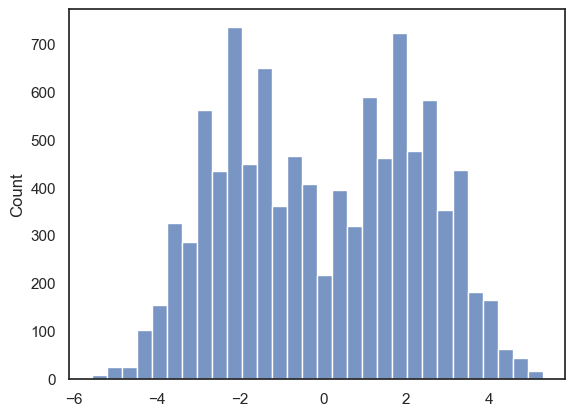

In [6]:
sns.histplot(results.null_distribution)
plt.show()

We can see that indeed, only in a few cases did the mean difference exceed 4.6.

The distribution of differences of means from shuffled data looks pretty odd (with two peaks). This probably reflects the fact that whether the difference (Husbands-Wives) is positive or negative is strongly influenced by whether the hich-sock person (with 48 pairs of socks) happens to be labelled as a husband or a wife; one peak in the null distribution will be shuffles where that person was labelled as male, and the other rpeak will be shuffles where they were labelled as female.

### The $p$ value

We can calculate the exact proportion of cases in which the mean difference in socks owned for [Husband-Wife] exceeds the value we observed in our original sample, 4.6, as follows:

In [7]:
# check which values is the null distribution are greater than 4.6 and code as 1/0
# then use the numpy function np.mean() to get the avergae of those ones and zeros (ie he proportion of 1s)
np.mean(results.null_distribution >= 4.57)

0.006

The proportion of shuffles in which the mean difference is greater than 4.6 is 0.004, 0.4%, or 40 of the 10,000 shuffles; we can check the last one a different way (just as a sanity check!)

In [8]:
sum(results.null_distribution >= 4.57)

60

#### Interpretation

If we simulate a situation in which sex does not determine the number of socks owned (but preserving some other important features of the dataset like the high skew, and the correlation between husabnds and their wives), there is only a 0.4% chance that we would get an apparent sex difference as large as the one we observed in our 'real' data.

The probability that the test statistic (in this case, the mean difference in pairs of socks owned) would be observed if the null hypothesis were true, is sometimes called the <b><i>$p$-value</i></b>. 

Our permutation test shows that the $p$-value associated with the observed difference of means is 0.4% or p=0.0004.

The result is considered statistically significant if $p$ is smaller than some predetermined level, known as $\alpha$. Usually $\alpha = 0.05$ or $\alpha = 0.01$ is used, so the result is significant if $p<0.05$ or $p<0.01$. Our result is therefore statistically significant.

In [9]:
print(results.null_distribution.size)

10000


## Syntax of `stats.permutation_test()`

Let's have a look at the Python code to run the permutation test.

Firstly, we had to give the function `stats.permutation_test()` our two samples <tt>(socks.Husband, socks.Wife)</tt> as a pair of <b>series</b> (individual columns from the dataframe), rather than giving it the whole pandas dataframe as we do for many other stats functions.

Secondly, to tell `stats.permutation_test()` the test statistic we want to get the null distribution of, we had to pass it a *function* that calculates that test statistic. We created that function, `mDiff()`, using a function definition, before running the permutation test

### Arguments

When running the permutation test, we have to specify some arguments

* **n_resamples** the number of shuffles to do.
* **alternative** - whether to do a one-tailed test (and in whcih direction: 'greater' counts how many shuffles result in test statistic values greater than the one obtained from unshuffled data) or a two tailed test
* **permutation_type** - pairings, samples, or independent. These are for test of correlation, paired data and unpaired data respectively.

Here we are testing for a mean difference in paired data, so we choose `permutation_type='samples'`; the samples in this case are the men and women (husbands and wives) - we are permuting the data by moving people between samples (flipping husband/wife labels) but not moving people between couples.


## Recap

To run a permutation test on paired data, we randomly flipped some of the pairs so that the husband's sock count was assigned to the wife and vice versa. We did NOT move people between couples, as we want to retain the characteristic of the original dataset that high-sock husbands tend to have high-sock wives

For each shuffle we calculated the mean (pairwise) difference in the number of socks - husband-wife. 

Permutation testing in this way gives us a null distribution for the mean difference. Values of mean difference that occur rarely in the null distribution are considered statistically significant.
    
To run the permutation test with <tt>scipy.stats</tt> we need the option `permutation_type='samples'`